# ML Models
---

## Libraries

In [ ]:
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings("ignore")

import re

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(palette="muted")

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from xgboost import XGBRegressor


from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt


from scipy.stats import bootstrap

---
## Load data

In [26]:
# Original dataset after ETL
df = pd.read_csv('..\\datasets\\2. Processed Dataset\\result.csv')
df = df.drop(columns=["id"], errors="ignore")
# PCA dataset + One-Hotenconded
df_pca = pd.read_csv('..\\datasets\\2. Processed Dataset\\pca_result.csv')

---
## First approach models training

In [ ]:
# Split of the dataset into features and target
X = df_pca
y = df['Salary'] 

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0) # 25% test

# Standardize Salary
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Initialize and train models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=0),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=0),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=0)
}


,MAE,RMSE,%RMSE,R²
Linear Regression,9579.996905,13087.342629,13.079736,0.926195
Random Forest,7737.373188,11778.308812,11.771463,0.940221
XGBoost,8030.985946,12429.488262,12.422264,0.933429
Neural Network,9782.020775,12843.881605,12.836417,0.928916


In [ ]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train_scaled)  # Train
    y_pred_scaled = model.predict(X_test)  # Predict
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()  # Inverse scale

    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_percentage = (rmse / y_test.mean()) * 100
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "%RMSE": rmse_percentage, "R²": r2}

# Display results
pd.DataFrame(results).T

---
### Model Hyperparameter Tunning with Grid Search

In [40]:
# Split of the dataset into features and target
X = df_pca
y = df['Salary'] 

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Standardize Salary
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()


# Hyperparameter grids
param_grids = {
    "Linear Regression": {},
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [2, 4, 8, 10, 20, None],
        "min_samples_split": [2, 5, 10, 20]  
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2],
    },
    "Neural Network": {
        'hidden_layer_sizes': [(64,), (128, 64), (64, 32)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01, 0.1]
    }
}

# Initialize models
models = {
    "Linear Regression":LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=0),
    "XGBoost": XGBRegressor(random_state=0),
    "Neural Network": MLPRegressor(max_iter=500, random_state=0)
}

In [ ]:
# Train models with hyperparameter tuning
best_models = {}
for name, model in models.items():
    if name in param_grids:
        search = GridSearchCV(model, param_grids[name], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
        search.fit(X_train, y_train_scaled)  # 
        best_models[name] = search.best_estimator_
        print(f"✅ Best params for {name}: {search.best_params_}")
    else:
        model.fit(X_train, y_train_scaled)
        best_models[name] = model


# Compute and display model metrics
results = []
for name, model in best_models.items():
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # Compute metrics   
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_percentage = (rmse / y_test.mean()) * 100
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": f"{mae:.2f}",
        "RMSE": f"{rmse:.2f}",
        "%RMSE": f"{rmse_percentage:.2f} ",
        "R²": f"{r2:.2f} ",
    })

# Display results in table format
df_results = pd.DataFrame(results)
df_results

✅ Best params for Linear Regression: {}
✅ Best params for Random Forest: {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 300}
✅ Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
✅ Best params for Neural Network: {'alpha': 0.01, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01}


,Model,MAE,RMSE,%RMSE,R²
0,Linear Regression,9580.00,13087.34,13.08,0.93
1,Random Forest,8281.45,12637.87,12.63,0.93
2,XGBoost,8645.05,12102.86,12.10,0.94
3,Neural Network,6906.78,9880.52,9.87,0.96


---
## Overfitting Evaluation

### Compare Training vs. Test Performance

In [42]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Inverse scale predictions
    y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
    y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()

    print(f"{model_name} Performance:")
    print(f"Train R²: {r2_score(y_train, y_train_pred):.2f} | Test R²: {r2_score(y_test, y_test_pred):.2f}")
    print(f"Train RMSE: {root_mean_squared_error(y_train, y_train_pred):.2f} | Test RMSE: {root_mean_squared_error(y_test, y_test_pred):.2f}")
    print("-" * 50)

# Apply this function to all trained models
for name, model in best_models.items():
    evaluate_model(model, X_train, y_train, X_test, y_test, name)

Linear Regression Performance:
Train R²: 0.92 | Test R²: 0.93
Train RMSE: 13623.02 | Test RMSE: 13087.34
--------------------------------------------------
Random Forest Performance:
Train R²: 0.97 | Test R²: 0.93
Train RMSE: 8432.13 | Test RMSE: 12637.87
--------------------------------------------------
XGBoost Performance:
Train R²: 0.98 | Test R²: 0.94
Train RMSE: 7306.06 | Test RMSE: 12102.86
--------------------------------------------------
Neural Network Performance:
Train R²: 0.95 | Test R²: 0.96
Train RMSE: 10943.24 | Test RMSE: 9880.52
--------------------------------------------------


### Cross-Validation

In [44]:
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

def cross_validate_model(model, X, y, cv=5):
    """ Realiza validación cruzada y muestra los resultados de R² """
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
    mean_r2, std_r2 = scores.mean(), scores.std()
    print(f"Cross-Validation R²: {mean_r2:.2f} ± {std_r2:.2f}")

# Aplicar validación cruzada en los mejores modelos
for name, model in best_models.items():
    print(f"{name} Cross-Validation:")
    cross_validate_model(model, X, y_scaled)
    print("-" * 50)

Linear Regression Cross-Validation:
Cross-Validation R²: 0.90 ± 0.05
--------------------------------------------------
Random Forest Cross-Validation:
Cross-Validation R²: 0.89 ± 0.07
--------------------------------------------------
XGBoost Cross-Validation:
Cross-Validation R²: 0.90 ± 0.05
--------------------------------------------------
Neural Network Cross-Validation:
Cross-Validation R²: 0.92 ± 0.03
--------------------------------------------------


### Conclusions
- Linear Regression
    - Train R²: 0.92 | Test R²: 0.93 - Train and Test R² are close what suggest is doing a good generalization.
    - RMSE values are also close → No large performance drop.
    - Cross-validation confirms stability (0.90 ± 0.05)
    
- Random Forest: 
    - Train R²: 0.97 | Test R²: 0.93 - R2 Train is much grater than Test R2, the model is overfitting.
    - Train RMSE (8432.13) vs Test RMSE (12637.87) - Large gap suggests overfitting
    
- XGBoost
    - Train R²: 0.98 | Test R²: 0.94 and Train RMSE: 7306.06 | Test RMSE: 12102.86 the model is overfitting.
    - Cross-validation is stable (0.90 ± 0.05)
    - Second best model with a slight overfitting bus stable performance.

- Neural Network:
    - Train R²: 0.95 | Test R²: 0.96 and Train RMSE: 10943.24 | Test RMSE: 9880.52 shows a balance model and no major overfitting despite being a more complex model.
    - Cross-Validation shows highest mean R² (0.92) with lowest variance (±0.03) suggesting a strong generalization to unseen data.
    - Best overall model

---
### Validation Curves for XGBoost and Neural Networks
- Random Forest:
    - min_samples_split
        - Best fit was 2 for "min_samples_split": [1, 2, 5, 10, 20]
        - For low values of min_samples_split (left side, near 2-10), the model shows overfitting.
        - Increasing min_samples_split (moving right, 20-50) both scores decrease gradually.The gap between training and validation scores narrows, which means the model is becoming less overfitted and generalizing better.
        - For high values of min_samples_split (above 50) the model starts to underfit, training and validation score also drop meaning the model is not complex enough to capture important patterns in the data.
        - The optimal range of min_samples_split is between 10 and 30 seems to be a good choice since it balances training and validation performance.
    - max_depth
        - Best fit was 20 for "max_depth": [2, 4, 8, 10, 20, None]
        - For small max_depth (1-5) both training (blue) and validation (red) scores increase steeply. At max_depth = 5, the model reaches high validation performance (~0.92). This suggests that with a low max_depth, the model was underfitting but quickly improved as depth increased.
        - For larger max_depth (5-15) training score continues increasing and approaches 1.0 (perfect fit). Validation score plateaus around 0.92-0.93, indicating that further increases in depth do not improve generalization.
        - For very high max_depth (>15) training score remains at 1.0, showing that the model is memorizing the training data (overfitting). Validation score stays constant (~0.92), meaning deeper trees do not improve performance. The widening gap between training and validation scores suggests increasing overfitting.
        - The optimal range for max_depth is between 5-10.
    

- XGBoost:
Best params for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best params for Linear Regression: {}
Best params for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 6, 10]

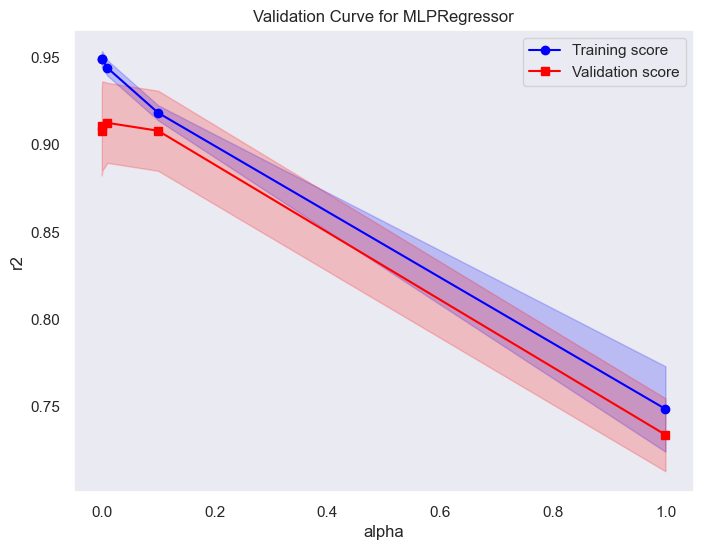

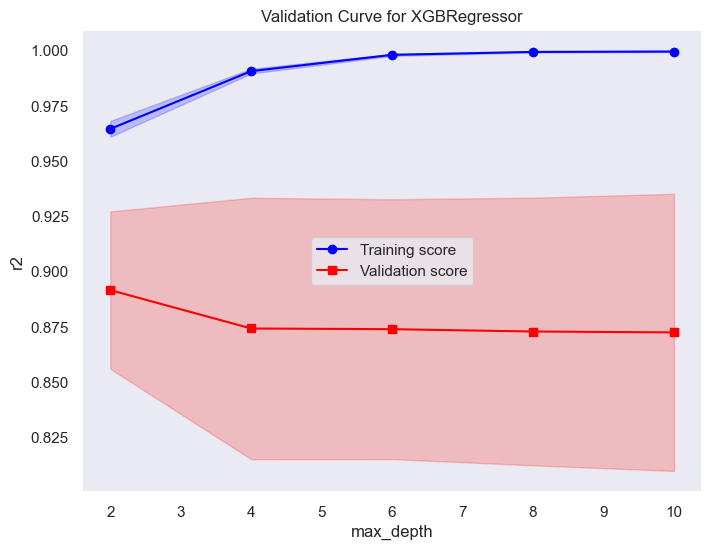

In [46]:
# Function to plot validation curves
def plot_validation_curve(model, X_train, y_train, param_name, param_range, scoring="r2"):
    train_scores, test_scores = validation_curve(
        model, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, scoring=scoring, n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(param_range, train_mean, label="Training score", color="blue", marker='o')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
    plt.plot(param_range, test_mean, label="Validation score", color="red", marker='s')
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)
    
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.legend()
    plt.grid()
    plt.show()

# Validation curve for Neural Network (MLPRegressor) - Alpha
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), learning_rate_init=0.01, max_iter=500, random_state=0)
param_range = [0.0001, 0.001, 0.01, 0.1, 1]
plot_validation_curve(nn_model, X_train, y_train_scaled, "alpha", param_range)

# Validation curve for XGBoost - Max Depth
xgb_model = XGBRegressor(learning_rate=0.1, n_estimators=100, random_state=0)
param_range = [2, 4, 6, 8, 10]
plot_validation_curve(xgb_model, X_train, y_train_scaled, "max_depth", param_range)


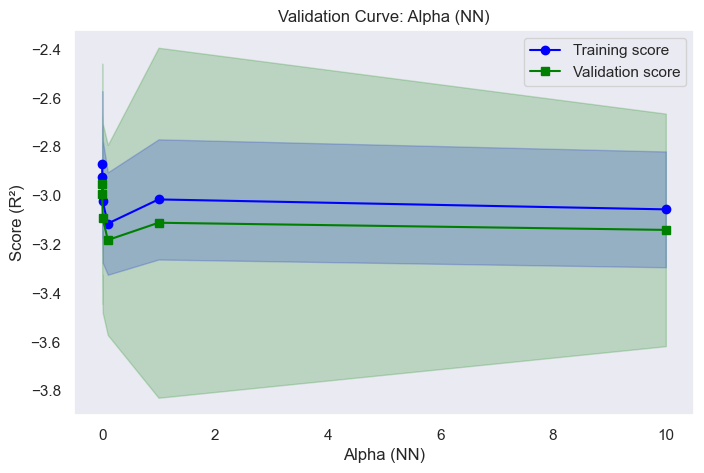

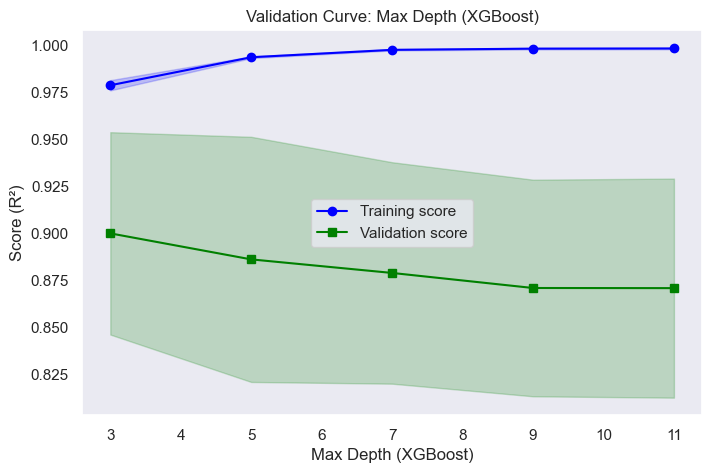

In [45]:
# Split of the dataset into features and target
X = df_pca
y = df['Salary'] 

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Standardize Salary
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Define parameter ranges
hidden_layer_sizes_range = [(32,), (64,), (64,32), (128,64), (128,64,32)]
alpha_range = np.logspace(-4, 1, 6)  # [0.0001, 0.001, 0.01, 0.1, 1, 10]
max_depth_range = [3, 5, 7, 9, 11]
learning_rate_range = np.logspace(-3, 0, 4)  # [0.001, 0.01, 0.1, 1]

# Function to plot validation curve
def plot_validation_curve(param_range, train_scores, test_scores, param_name):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.plot(param_range, test_mean, label="Validation score", color="green", marker="s")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="green")

    plt.xlabel(param_name)
    plt.ylabel("Score (R²)")
    plt.title(f"Validation Curve: {param_name}")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Validation curve for Neural Network - Alpha
train_scores, test_scores = validation_curve(
    MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500),
    X, y, param_name="alpha", param_range=alpha_range, scoring="r2", cv=5, n_jobs=-1
)
plot_validation_curve(alpha_range, train_scores, test_scores, "Alpha (NN)")

# Validation curve for XGBoost - Max Depth
train_scores, test_scores = validation_curve(
    XGBRegressor(n_estimators=100, learning_rate=0.1),
    X, y, param_name="max_depth", param_range=max_depth_range, scoring="r2", cv=5, n_jobs=-1
)
plot_validation_curve(max_depth_range, train_scores, test_scores, "Max Depth (XGBoost)")

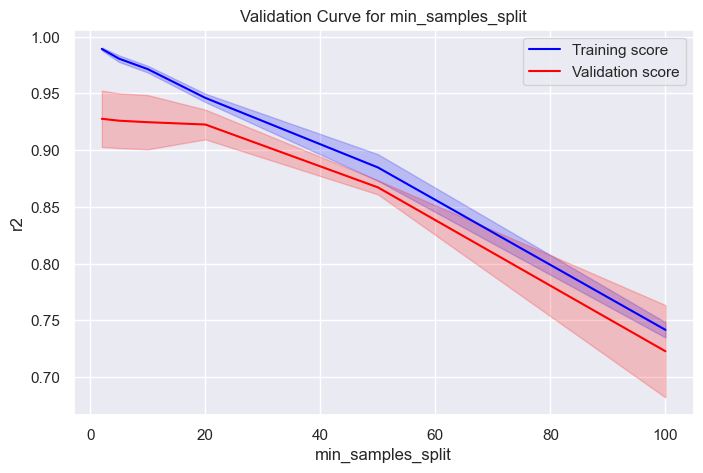

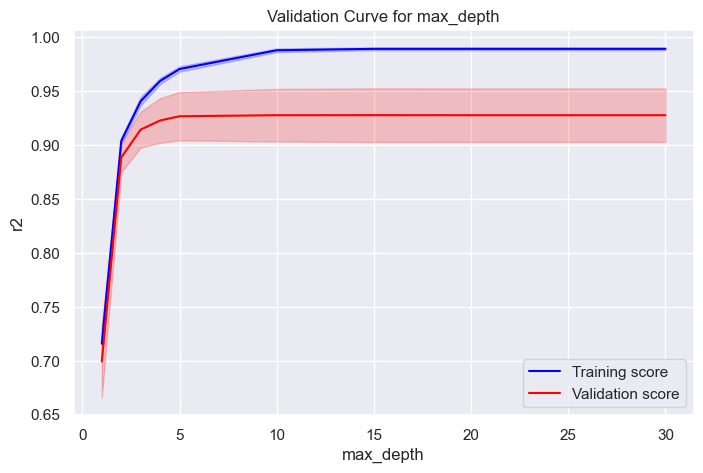

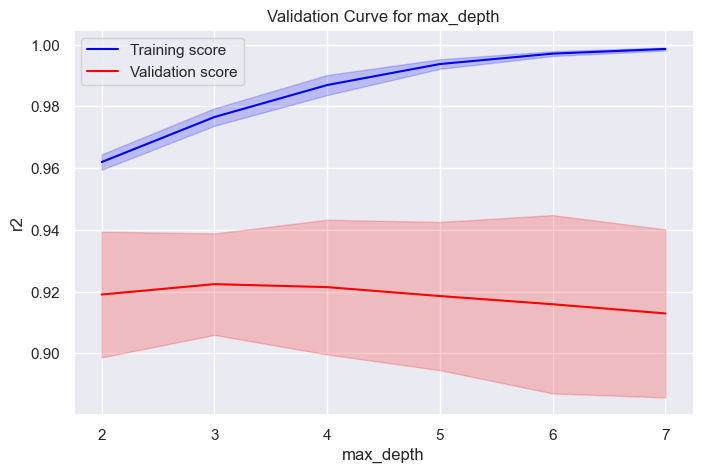

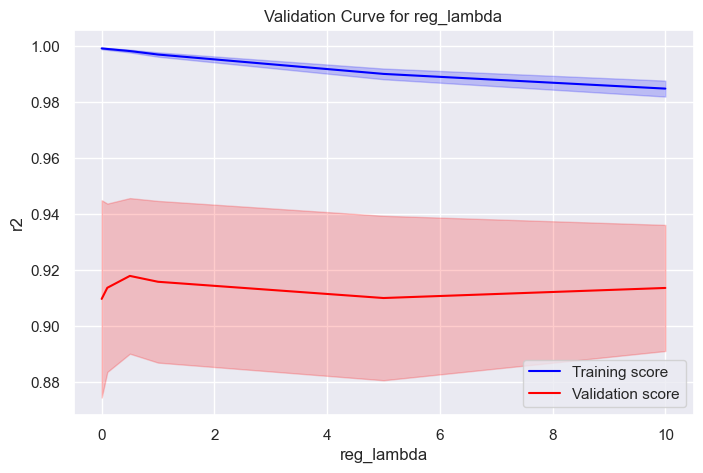

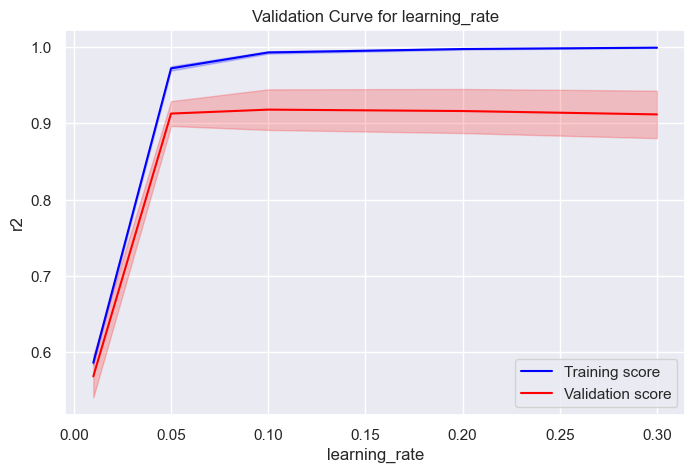

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Function to plot validation curves
def plot_validation_curve(estimator, param_name, param_range, X_train, y_train, scoring='r2'):
    train_scores, test_scores = validation_curve(
        estimator, X_train, y_train, param_name=param_name, param_range=param_range,
        cv=5, scoring=scoring, n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(param_range, train_mean, label="Training score", color="blue")
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.plot(param_range, test_mean, label="Validation score", color="red")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="red")
    
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.title(f"Validation Curve for {param_name}")
    plt.legend()
    plt.show()

# ------------------ RANDOM FOREST ------------------
# Tuning min_samples_split - Increasing to reduce overfitting - Best fit was 2 for "min_samples_split": [1, 2, 5, 10, 20]
rf_model = RandomForestRegressor(n_estimators=200, random_state=0)
param_range = [2, 5, 10, 20, 50, 100]
plot_validation_curve(rf_model, 'min_samples_split', param_range, X_train, y_train)

# Tuning max_depth (Reducing to avoid overfitting)  - Best fit was 20 for "max_depth": [2, 4, 8, 10, 20, None]
param_range = [1, 2, 3, 4, 5, 10, 15, 20, 30]
plot_validation_curve(rf_model, 'max_depth', param_range, X_train, y_train)

# ------------------ XGBOOST ------------------
# Tuning max_depth (Reducing overfitting)
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.2, random_state=0)
param_range = [2, 3, 4, 5, 6, 7]
plot_validation_curve(xgb_model, 'max_depth', param_range, X_train, y_train)

# Tuning lambda (L2 Regularization, Increasing to reduce overfitting)
param_range = [0, 0.1, 0.5, 1, 5, 10]
plot_validation_curve(xgb_model, 'reg_lambda', param_range, X_train, y_train)

# Tuning learning_rate (Reducing to avoid high variance)
param_range = [0.01, 0.05, 0.1, 0.2, 0.3]
plot_validation_curve(xgb_model, 'learning_rate', param_range, X_train, y_train)

In [ ]:
# Define a simple feedforward neural network
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Predictions
y_pred_nn = model.predict(X_test).flatten()

print(f"Keras -> MAE: {mean_absolute_error(y_pred_nn, y_pred):.2f}, "
        f"RMSE: {np.sqrt(mean_squared_error(y_pred_nn, y_pred)):.2f}, "
        f"R²: {r2_score(y_pred_nn, y_pred):.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Keras -> MAE: 92780.63, RMSE: 102637.89, R²: -2966.01


In [ ]:
# Confidence Intervals
boot_metrics = {"MAE": [], "RMSE": [], "R2": []}
num_bootstrap = 1000

for _ in range(num_bootstrap):
    indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
    y_test_sample = y_test.iloc[indices]
    y_pred_sample = y_pred_rf[indices]
    metrics = compute_metrics(y_test_sample, y_pred_sample)
    for key in boot_metrics:
        boot_metrics[key].append(metrics[key])

ci_95 = {metric: (np.percentile(values, 2.5), np.percentile(values, 97.5)) for metric, values in boot_metrics.items()}

# Print results
print("Dummy Model:", results_dummy)
print("Random Forest Model:", results_rf)
print("95% Confidence Intervals:", ci_95)

Dummy Model: {'MAE': 40690.50882167612, 'RMSE': 48180.83218379831, 'R2': -0.00029651269527053437}
Random Forest Model: {'MAE': 8187.810127674259, 'RMSE': 13129.306241630149, 'R2': 0.9257213986110274}
95% Confidence Intervals: {'MAE': (6309.50532694962, 10553.800724637682), 'RMSE': (9490.532520796181, 16744.374987512587), 'R2': (0.8704464400847671, 0.9602581561171868)}


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, scoring='neg_mean_absolute_error', cv=3)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

best_rf = grid_search.best_estimator_